# Time Slider Setup

This notebook adds one or more date fields to an existing feature class and populates these date fields with a scaled version of the original date or dates of the data. The scaled date fields can then be used to time-enable the data in ArcGIS Online and add a time slider, with custom JavaScript displaying the original date fields as labels.

### Define some variables.

In [1]:
# These first two values are items that should already exist in your ArcGIS Pro project.
# fc: existing feature layer of data to be mapped
fc = "CorinthPolyCombined"
# map_name: the map containing this feature layer
map_name = "TimeScaleMap"

# The following variables are used in publishing the feature's service definition to ArcGIS Online (AGOL).
# These don't exist yet, so you can use whatever information you want (as long as it follows AGOL rules).
service_name = "TimeScalesCorinthExample"
sd_description = "This dataset is extracted from the GIS data from ASCSA Corinth Excavations. This feature layer is a combination of the Greek, Roman, and Frankish polygon layers. Note that this layer was created solely for use in illustrating the creation of online maps with time sliders spanning non-standard date ranges. This layer should not be used for any reference purposes."
sd_summary = "Combined polygon layers from https://www.arcgis.com/home/item.html?id=f5e717c8341347a5b773d9c5e3512fdf"
sd_tags = "timescales, corinth" # Add other tags as desired
sd_credits = "ASCSA Corinth Excavations" # Include any credits for your feature layer here, if applicable

## Add scaled dates to data to use with time slider

Define which tables we're using and what the original date field(s) is.

In [2]:
# These should be the column names of the date fields containing the actual dates.
# If you're working with a single column, change the date_range variable here to False; you can ignore datefield2.
date_range = True
datefield1 = "ChronEarly"
if date_range:
    datefield2 = "ChronLate"

### Add the fields to hold the scaled dates

First we'll get a list of the existing fields.

In [3]:
lstFields = [f.name for f in arcpy.ListFields(fc)]

Now define the field(s) we'll add to hold the scaled dates.

These fields will be added to the data to hold scaled versions of the original date values.

In [4]:
scaledfield1 = "ScaledEarliestDate"

if scaledfield1 in lstFields:
    print(f"WARNING! {scaledfield1} already exists!")
    print("If you do not want this field to be overwritten, change the value of scaledfield1 above and rerun this cell before continuing.")
    print(f"If you continue, the values in {scaledfield1} will be overwritten.")

In [7]:
result = arcpy.management.AddFields(fc, scaledfield1 + " DATE # # # #;")

Now do the same for the second date column.

If you have a single date column (as opposed to a range of date represented by two columns), skip the next cells.

In [8]:
scaledfield2 = "ScaledLatestDate"

if scaledfield1 in lstFields:
    print(f"WARNING! {scaledfield2} already exists!")
    print("If you do not want this field to be overwritten, change the value of scaledfield2 above and rerun this cell before continuing.")
    print(f"If you continue, the values in {scaledfield1} will be overwritten.")

In [9]:
result = arcpy.management.AddFields(fc, scaledfield2 + " DATE # # # #;")

### Calculate scaled dates

First we'll figure out what the actual date range we're working with is. 

In [10]:
# Get a list of all the valid values in each date column
earlydates = [row[0] for row in arcpy.da.SearchCursor(fc, datefield1) if row[0]]
if date_range:
    latedates = [row[0] for row in arcpy.da.SearchCursor(fc, datefield2) if row[0]]

In [11]:
# Find the largest and smallest values. 
# Note that + concatenates the list (it's not adding).
if date_range:
    earliest = min(earlydates + latedates)
    latest = max(earlydates + latedates)
else:
    earliest = min(earlydates)
    latest = max(earlydates)
print(f"Earliest date found: {earliest}")
print(f"Latest date found: {latest}")

Earliest date found: -725.0
Latest date found: 1802.0


In [12]:
# Figure out how many years this is.
year_range = latest - earliest
print(f"Year range: {year_range}")

Year range: 2527.0


**This section defines how the years will be scaled. 
You might want to tweak these values to get the outcome you desire.**

We'll use 1900-2150 as the output date range to get a scale of about 10 scaled years to 1 original year.

Note that this means we'll lose some resolution, since we're compressing 2527 years into 250 years.

In [13]:
# These are the values that can be adjusted
scaled_years = 250
start_date = 1900
# Everything past this is calculated.
end_date = start_date + 250
print(f"Scaled date range: {start_date} to {end_date}")

Scaled date range: 1900 to 2150


In [14]:
scale_factor = scaled_years/(latest-earliest)
offset = end_date - (scaled_years*latest)/(latest-earliest)
print("The following values will be used in your JavaScript file! Save these for reference.")
print(f"scaleFactor: {round(scale_factor,4)}")
print(f"offset: {round(offset,4)}")

The following values will be used in your JavaScript file! Save these for reference.
scaleFactor: 0.0989
offset: 1971.7254


In [16]:
# Check to make sure it comes out correctly
# This should not throw an error. 
assert(abs(earliest * scale_factor + offset - start_date) < 1)
assert(abs(latest * scale_factor + offset - end_date) < 1)

Apply the above calculation to the newly created column values.

Calculate the scaled year, and apply an arbitrary date (Feb. 1 in this case) that is not Jan 1, to avoid time zones causing inadvertent year shifts.

In [18]:
arcpy.management.CalculateField(fc, 
                                scaledfield1, 
                                f"datetime.datetime(round({scale_factor} * !{datefield1}! + {offset}),2,1)", "PYTHON3")
if date_range:
    arcpy.management.CalculateField(fc, 
                                    scaledfield2, 
                                    f"datetime.datetime(round({scale_factor} * !{datefield2}! + {offset}),2,1)", "PYTHON3")

## Publish the layer to ArcGIS Online

Check the current portal connection.

In [19]:
import os
from arcgis import GIS
from arcgis.features import FeatureLayerCollection
import xml.dom.minidom as DOM 

In [20]:
gis = GIS("Pro")

If you're running this notebook outside ArcGIS Pro OR are not already signed into a portal, uncomment the following line and sign in to your portal.


In [68]:
# gis = GIS("https://www.arcgis.com", "MyUsername", "MyPassword")

In [21]:
# Set output directory
project = arcpy.mp.ArcGISProject("CURRENT").filePath
outdir = os.path.dirname(project)
print(outdir)

C:\Users\aheinlei\Documents\ArcGIS\Projects\HugeTimeScales


Set output filenames

In [22]:
# Set output filenames
sddraft_filename = service_name + ".sddraft"
sddraft_output_filename = os.path.join(outdir, sddraft_filename)
sd_filename = service_name + ".sd"
sd_output_filename = os.path.join(outdir, sd_filename)

Create a service definition draft, after checking to see if this service definition already exists.

In [23]:
# Get the layer to use
m = arcpy.mp.ArcGISProject("CURRENT").listMaps("TimeScaleMap")[0]
lyr = m.listLayers(fc)[0]
lyr

In [24]:
# Create FeatureSharingDraft 
# https://pro.arcgis.com/en/pro-app/latest/arcpy/mapping/createweblayersddraft.htm
server_type = "HOSTING_SERVER"
# sddraft = m.getWebLayerSharingDraft(server_type, "FEATURE", service_name)
arcpy.mp.CreateWebLayerSDDraft(lyr, sddraft_output_filename, service_name, 'MY_HOSTED_SERVICES', 'FEATURE_ACCESS')
# Check whether a service with this name already exists
if len(gis.content.search('title: ' + service_name)) > 0:
    print("WARNING! A service with this name already exists. Either delete the existing service or choose a different service_name (near the top of this notebook).")

In [25]:
# Define a function to update individual fields of metadata in the service definition draft file 
def changeProperty(doc, prop_name, new_value):
    descriptions = doc.getElementsByTagName(prop_name)

    for desc in descriptions:
        if desc.parentNode.tagName == 'ItemInfo':
            # modify the Description
            if desc.hasChildNodes():
                desc.firstChild.data = new_value
            else:
                txt = doc.createTextNode(new_value)
                desc.appendChild(txt)
    return(doc)

In [26]:
# Update the service definition draft with the desired metadata. 
# Parse the file as xml
sd_xml = DOM.parse(sddraft_output_filename)
# Update the fields
sd_xml = changeProperty(sd_xml, 'Snippet', sd_summary)
sd_xml = changeProperty(sd_xml, 'Description', sd_description)
sd_xml = changeProperty(sd_xml, 'Credits', sd_credits)
sd_xml = changeProperty(sd_xml, 'Tags', sd_tags)
# Write out the updated version
f = open(sddraft_output_filename, 'w')     
sd_xml.writexml( f )     
f.close() 

In [27]:
# Stage Service
print("Start Staging")
arcpy.StageService_server(sddraft_output_filename, sd_output_filename)

# Share to portal
print("Start Uploading")
uploaded = arcpy.UploadServiceDefinition_server(sd_output_filename, server_type)

print("Finish Publishing")

Start Staging
Start Uploading
Finish Publishing


### Get a reference to the newly created layer, share it, and time-enable

In [28]:
# The id of the layer in ArcGIS Online is index 3 in the returned array.
layer_id = uploaded[3]
layer = gis.content.get(layer_id)

<Item title:"TimeScalesCorinthExample" type:Feature Layer Collection owner:aheinlei_umich>
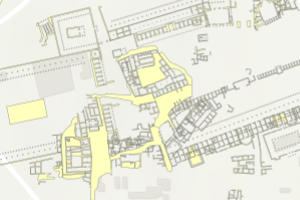

In [29]:
layer

This next line is optional and will publicly share the feature layer.

In [30]:
layer.share(everyone=True)

{'results': [{'itemId': '1c5bcad792e24f7e8819369f2566726c', 'success': True, 'notSharedWith': []}]}

Access the data layer within the feature layer to time-enable it.

In [31]:
fl = layer.layers[0]
fl

<FeatureLayer url:"https://services1.arcgis.com/4ezfu5dIwH83BUNL/arcgis/rest/services/TimeScalesCorinthExample/FeatureServer/0">

In [32]:
# fl.properties

In [33]:
if date_range:
    timeInfo = {'timeInfo': {'startTimeField': scaledfield1, 'endTimeField': scaledfield2}}
else:
    timeInfo = {'timeInfo': {'startTimeField': scaledfield1, 'endTimeField': ''}}

In [34]:
fl.manager.update_definition(timeInfo)

{'success': True}

# The layer is now ready to be used in a web map!
### See the JavaScript file for template map code.